In [ ]:
# Use boto3 to get GOES data from AWS
# Based on https://github.com/HamedAlemo/visualize-goes16

In [28]:
import xarray as xr
import requests
import netCDF4
import boto3
from botocore import UNSIGNED
from botocore.client import Config
import matplotlib.pyplot as plt
%matplotlib inline

In [29]:
# Inputs
bucket_name = 'noaa-goes16'
product_name = 'ABI-L1b-RadF'
year = 2019
day_of_year = 79
hour = 14
band = 3
download_file = True

In [30]:
# Initialize s3 client
s3_client = boto3.client('s3', config=Config(signature_version=UNSIGNED))

In [31]:
def get_s3_keys(bucket, s3_client, prefix = ''):
    """
    Generate the keys in an S3 bucket.

    :param bucket: Name of the S3 bucket.
    :param prefix: Only fetch keys that start with this prefix (optional).
    """
    
    kwargs = {'Bucket': bucket}

    if isinstance(prefix, str):
        kwargs['Prefix'] = prefix

    while True:
        resp = s3_client.list_objects_v2(**kwargs)
        for obj in resp['Contents']:
            key = obj['Key']
            if key.startswith(prefix):
                yield key

        try:
            kwargs['ContinuationToken'] = resp['NextContinuationToken']
        except KeyError:
            break

In [32]:
# Get keys (full path names) of files meeting input criteria
keys = get_s3_keys(bucket_name,
                   s3_client,
                   prefix = f'{product_name}/{year}/{day_of_year:03.0f}/{hour:02.0f}/OR_{product_name}-M3C{band:02.0f}'
                   )

In [33]:
# Select the first measurement taken within the hour
key = [key for key in keys][0]
print(key)
file_name = key.split('/')[-1].split('.')[0]
print(file_name)

ABI-L1b-RadF/2019/079/14/OR_ABI-L1b-RadF-M3C03_G16_s20190791400366_e20190791411133_c20190791411180.nc
OR_ABI-L1b-RadF-M3C03_G16_s20190791400366_e20190791411133_c20190791411180


In [34]:
resp = requests.get(f'https://{bucket_name}.s3.amazonaws.com/{key}')
if download_file:
    open(file_name,'wb').write(resp.content)

In [35]:
# Read data into xarray 
nc4_ds = netCDF4.Dataset(file_name, memory = resp.content)
store = xr.backends.NetCDF4DataStore(nc4_ds)
DS = xr.open_dataset(store)

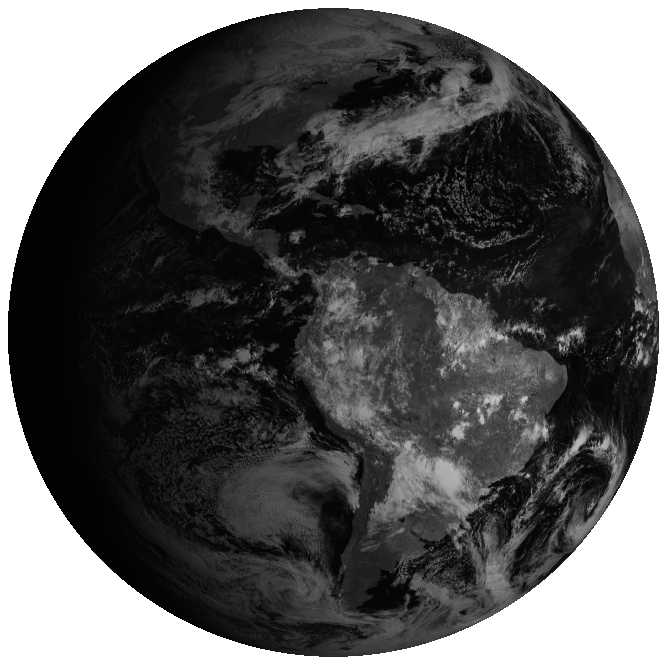

In [36]:
# Plot radiance data
fig = plt.figure(figsize=(12, 12))
plt.imshow(DS.Rad, cmap='gray')
plt.axis('off')
plt.savefig(f'{file_name}.png', dpi=300, facecolor='w', edgecolor='w')